In [17]:
# !pip install shap

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import sklearn
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.model_selection import cross_val_score, KFold
from imblearn.over_sampling import SMOTE
import shap

pd.set_option("display.max_columns", None)
from functions import *
import warnings
warnings.filterwarnings('ignore')

### Add Labels to Data

In [11]:
df_raw = pd.read_parquet("Data/Cleaned/after_kriging.parquet")
df = pd.read_parquet('Data/Cleaned/post_feat_engineering.parquet')
labels = pd.read_parquet('Data/Cleaned/labels_udp.parquet')

df = df.merge(labels[['GEOID','pred_year','label']], on=['GEOID','pred_year'], how='left')
df

,GEOID,total_pop,percent_hh_income_assist,percent_hh_snap,percent_hh_english,percent_work_agriculture,percent_work_construction,percent_work_retail,percent_work_finance,percent_work_stem,percent_work_edu_health,percent_work_art,percent_out_of_county,percent_moved_within_county,percent_public_transit,percent_drive_commute,percent_bike_commute,percent_walk_commute,percent_wfh,percent_white,percent_black,percent_native,percent_asian,percent_pacific,percent_latino,percent_bachelors,percent_grad,percent_born_citizen,percent_naturalized_citizen,percent_not_citizen,percent_same_house_1yr,percent_out_of_state,med_income,med_rent_acs,med_age,percent_hh_rented,med_value,percent_hh_electric,percent_hh_solar,med_hh_age,med_hh_tenure,num_citibike_rides,num_trees,med_rent,num_affordable_hous_built,num_bikelanes,num_evictions_commercial,num_evictions_residential,park_acres,num_parks,pred_year,lag_vulnerable,label
0,36005000100,-0.068661,0.035685,0.028985,0.001017,0.199477,0.045892,-0.017763,0.035731,0.022690,0.021284,0.054678,-0.014333,0.065448,0.000000,0.000000,0.000000,0.000000,0.000000,-0.006464,0.018035,0.277300,-0.000033,0.000000,-0.024075,-0.124830,0.449510,0.002733,0.025448,0.010323,-0.014150,-0.050057,0.005722,0.049193,0.004397,1.089373,0.008277,-0.005696,12.906525,-0.007878,-0.034566,0.0,0.040565,0.013164,0.000000,0.000000,0.144316,0.082033,0.0,0.0,2020,1.000000,2
1,36005000200,0.034962,0.218237,0.201764,-0.026817,-0.211255,-0.143559,-0.051058,0.005439,0.075584,0.050176,0.071833,-0.077578,-0.105136,0.033405,-0.021183,0.000000,0.138279,-0.377954,0.214509,-0.026615,-0.298942,-0.017225,0.000000,0.009071,0.057625,0.148837,-0.027422,0.023382,0.149468,0.009212,-0.077517,0.030404,-0.003322,0.049306,1.106573,0.001691,0.311270,0.000000,-0.021834,-0.021378,0.0,0.039684,0.000384,0.000000,0.000000,0.000000,0.000000,0.0,0.0,2020,0.574468,2
2,36005000400,0.034124,0.786830,0.168444,-0.006987,0.000000,-0.086546,0.085892,-0.119376,0.065526,-0.033501,0.236460,-0.107590,-0.004790,0.028070,-0.028604,-0.187822,-0.041648,2.037930,0.255629,0.070771,0.083326,-0.038641,0.000000,-0.016291,0.000209,0.032225,0.000973,0.054771,0.012176,0.007979,-0.229897,0.011434,0.009918,0.015270,-0.394797,-0.017437,1.049936,0.000000,-0.060346,-0.014822,0.0,0.065020,-0.002948,0.000000,0.070962,0.000000,0.051681,0.0,0.0,2020,0.723404,1
3,36005001600,0.028238,0.105534,0.119549,-0.037455,0.000000,-0.068067,0.070625,-0.016419,0.270917,-0.013170,0.057567,0.232766,-0.104326,-0.015358,-0.022066,0.000000,0.312918,-0.095215,0.168040,0.005470,0.000000,0.000000,0.000000,0.013476,0.015757,-0.076782,-0.031302,0.045230,0.142282,0.004117,-0.403649,0.008068,0.023547,-0.013855,7.142181,0.003578,0.013124,0.000000,-0.017877,-0.040687,0.0,0.063187,0.029170,0.000000,0.069444,0.000000,0.106212,0.0,0.0,2020,0.714286,1
4,36005001901,0.000644,-0.034693,0.006081,-0.001591,-0.081312,-0.047796,-0.014341,-0.055569,0.035664,-0.007433,0.090601,-0.102033,-0.018727,0.016370,-0.032029,0.232876,0.007768,0.041536,-0.064106,-0.018095,0.106253,-0.061774,0.422531,0.003428,0.049573,0.224663,0.004055,0.049740,-0.004173,0.002864,-0.171264,-0.018268,0.078083,0.001804,7.661378,-0.023169,-0.001365,-0.010289,0.026425,-0.039251,0.0,0.055470,0.016927,-0.520833,0.000000,0.000000,0.048778,0.0,0.0,2020,0.978723,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18595,36085030302,-0.001154,0.215473,0.011413,-0.021104,0.000000,-0.036738,-0.134240,-0.067538,0.016564,0.077345,0.148286,0.698988,-0.034859,0.041904,-0.004503,0.000000,0.209163,0.946175,-0.045150,0.086675,0.000000,0.011771,0.000000,0.008026,0.055342,0.008809,-0.009526,0.082499,-0.051934,0.002615,-0.173023,0.033478,0.025459,0.025387,-0.050505,0.064139,-0.006120,-0.066851,-0.011909,-0.032434,0.0,0.002710,0.018248,0.000000,0.000000,-1.000000,0.547619,0.0,0.0,2027,0.297872,0
18596,36085031901,0.061577,-0.0407

In [12]:
# remove observations with very small population
small_pop = df_raw[df_raw.total_pop <50].GEOID.unique()
df = df[df.GEOID.isin(small_pop)==False]


### Split Pred Set and Training set

In [27]:
# Split train/test/pred Set
pred_set = df[df.pred_year.isin(['2024','2025','2026','2027'])]
train_test_set_full = df[df.pred_year.isin(['2024','2025','2026','2027'])==False]

# limit train/test sets to vulnerable/gentrified tracts only
train_test_set = train_test_set_full[train_test_set_full.label!=0]

# define feature set and split data
feat = ['total_pop', 'percent_hh_income_assist', 'percent_hh_snap',
       'percent_hh_english', 'percent_work_agriculture',
       'percent_work_construction', 'percent_work_retail',
       'percent_work_finance', 'percent_work_stem', 'percent_work_edu_health',
       'percent_work_art', 'percent_out_of_county',
       'percent_moved_within_county', 'percent_public_transit',
       'percent_drive_commute', 'percent_bike_commute', 'percent_walk_commute',
       'percent_wfh', 'percent_white', 'percent_black', 'percent_native',
       'percent_asian', 'percent_pacific', 'percent_latino',
       'percent_bachelors', 'percent_grad', 'percent_born_citizen',
       'percent_naturalized_citizen', 'percent_not_citizen',
       'percent_same_house_1yr', 'percent_out_of_state', 'med_income',
       'med_rent_acs', 'med_age', 'med_value',
       'percent_hh_electric', 'percent_hh_solar', 'med_hh_age',
       'med_hh_tenure', 'num_citibike_rides', 'num_trees', 'med_rent',
       'num_affordable_hous_built', 'num_bikelanes','percent_hh_rented',
       'num_evictions_commercial', 'num_evictions_residential', 'park_acres',
       'num_parks', 'lag_vulnerable']

# labels
y_train_test = train_test_set['label']

# features
X_train_test = train_test_set[feat]

# Apply SMOTE to the training data to upsample minority class
smote = SMOTE(sampling_strategy='auto')
X_train_test, y_train_test = smote.fit_resample(X_train_test, y_train_test)


### Train with Cross Validation to report performance

In [28]:
# Random Forest

forest = RandomForestClassifier(n_estimators=100, random_state=65)

kf = KFold(n_splits=5, shuffle=True, random_state=65)
cv_scores = cross_val_score(forest, X_train_test, y_train_test, cv=kf, scoring="f1" )
print("CV Scores:", cv_scores)
print("Mean F1:", np.mean(cv_scores))


CV Scores: [0.88176796 0.86160714 0.86043829 0.87385321 0.86046512]
Mean F1: 0.8676263437821472


In [34]:
# Feature importances
forest.fit(X_train_test, y_train_test)
sorted(list(zip(forest.feature_importances_, X_train_test.columns)), reverse=True)


[(0.09937099483385124, 'percent_white'),
 (0.04890492211019776, 'med_rent_acs'),
 (0.04416994464228113, 'percent_bachelors'),
 (0.042579736840843777, 'med_rent'),
 (0.036032114426729, 'med_income'),
 (0.027464249292953963, 'percent_bike_commute'),
 (0.027324785406786057, 'percent_grad'),
 (0.024533960442613068, 'num_trees'),
 (0.022673771619289344, 'lag_vulnerable'),
 (0.021314148925854273, 'percent_asian'),
 (0.020833362091375447, 'percent_hh_english'),
 (0.02077934903916136, 'percent_hh_rented'),
 (0.01954055084606245, 'percent_latino'),
 (0.019530033419418346, 'percent_work_stem'),
 (0.019210481171913308, 'percent_walk_commute'),
 (0.018807973518171678, 'percent_out_of_state'),
 (0.018604805187763168, 'med_hh_tenure'),
 (0.01855523770199985, 'percent_black'),
 (0.018307522453833925, 'percent_drive_commute'),
 (0.018257044420149582, 'percent_hh_income_assist'),
 (0.018251106407211445, 'med_value'),
 (0.01782583576723296, 'percent_wfh'),
 (0.01774820456562417, 'percent_work_art'),
 (0

### Retrain on All Data for Final Preds

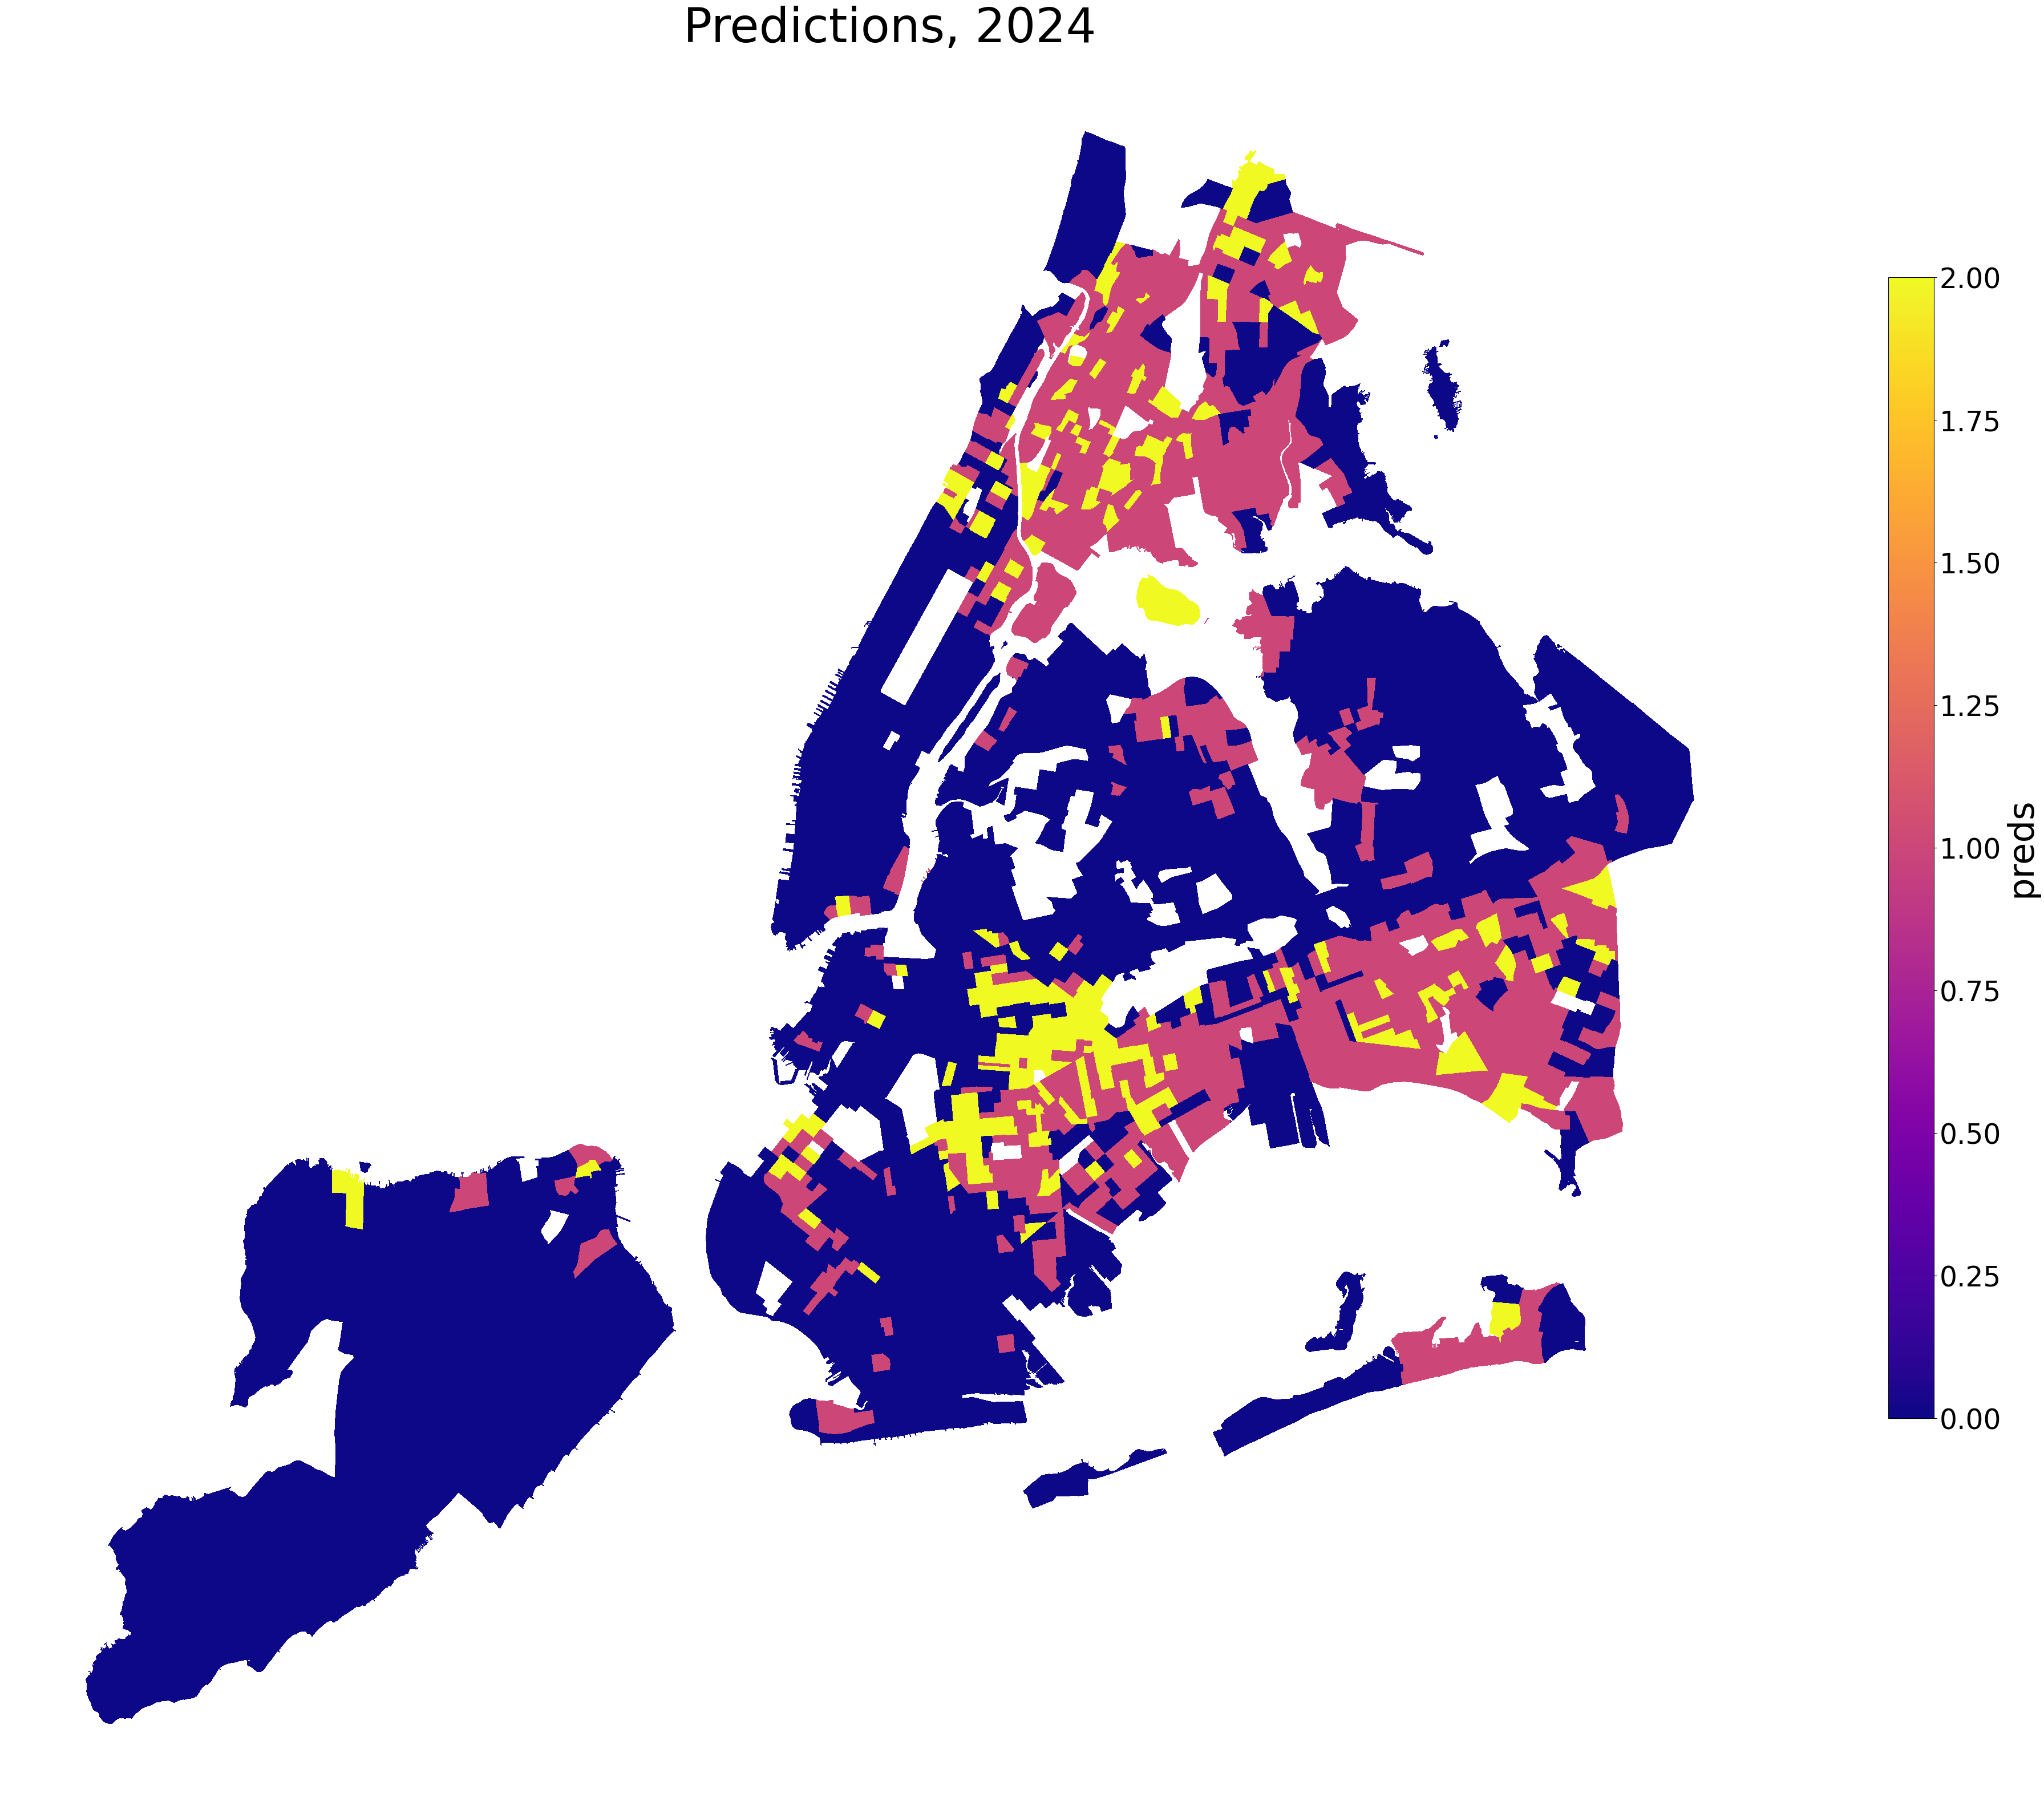

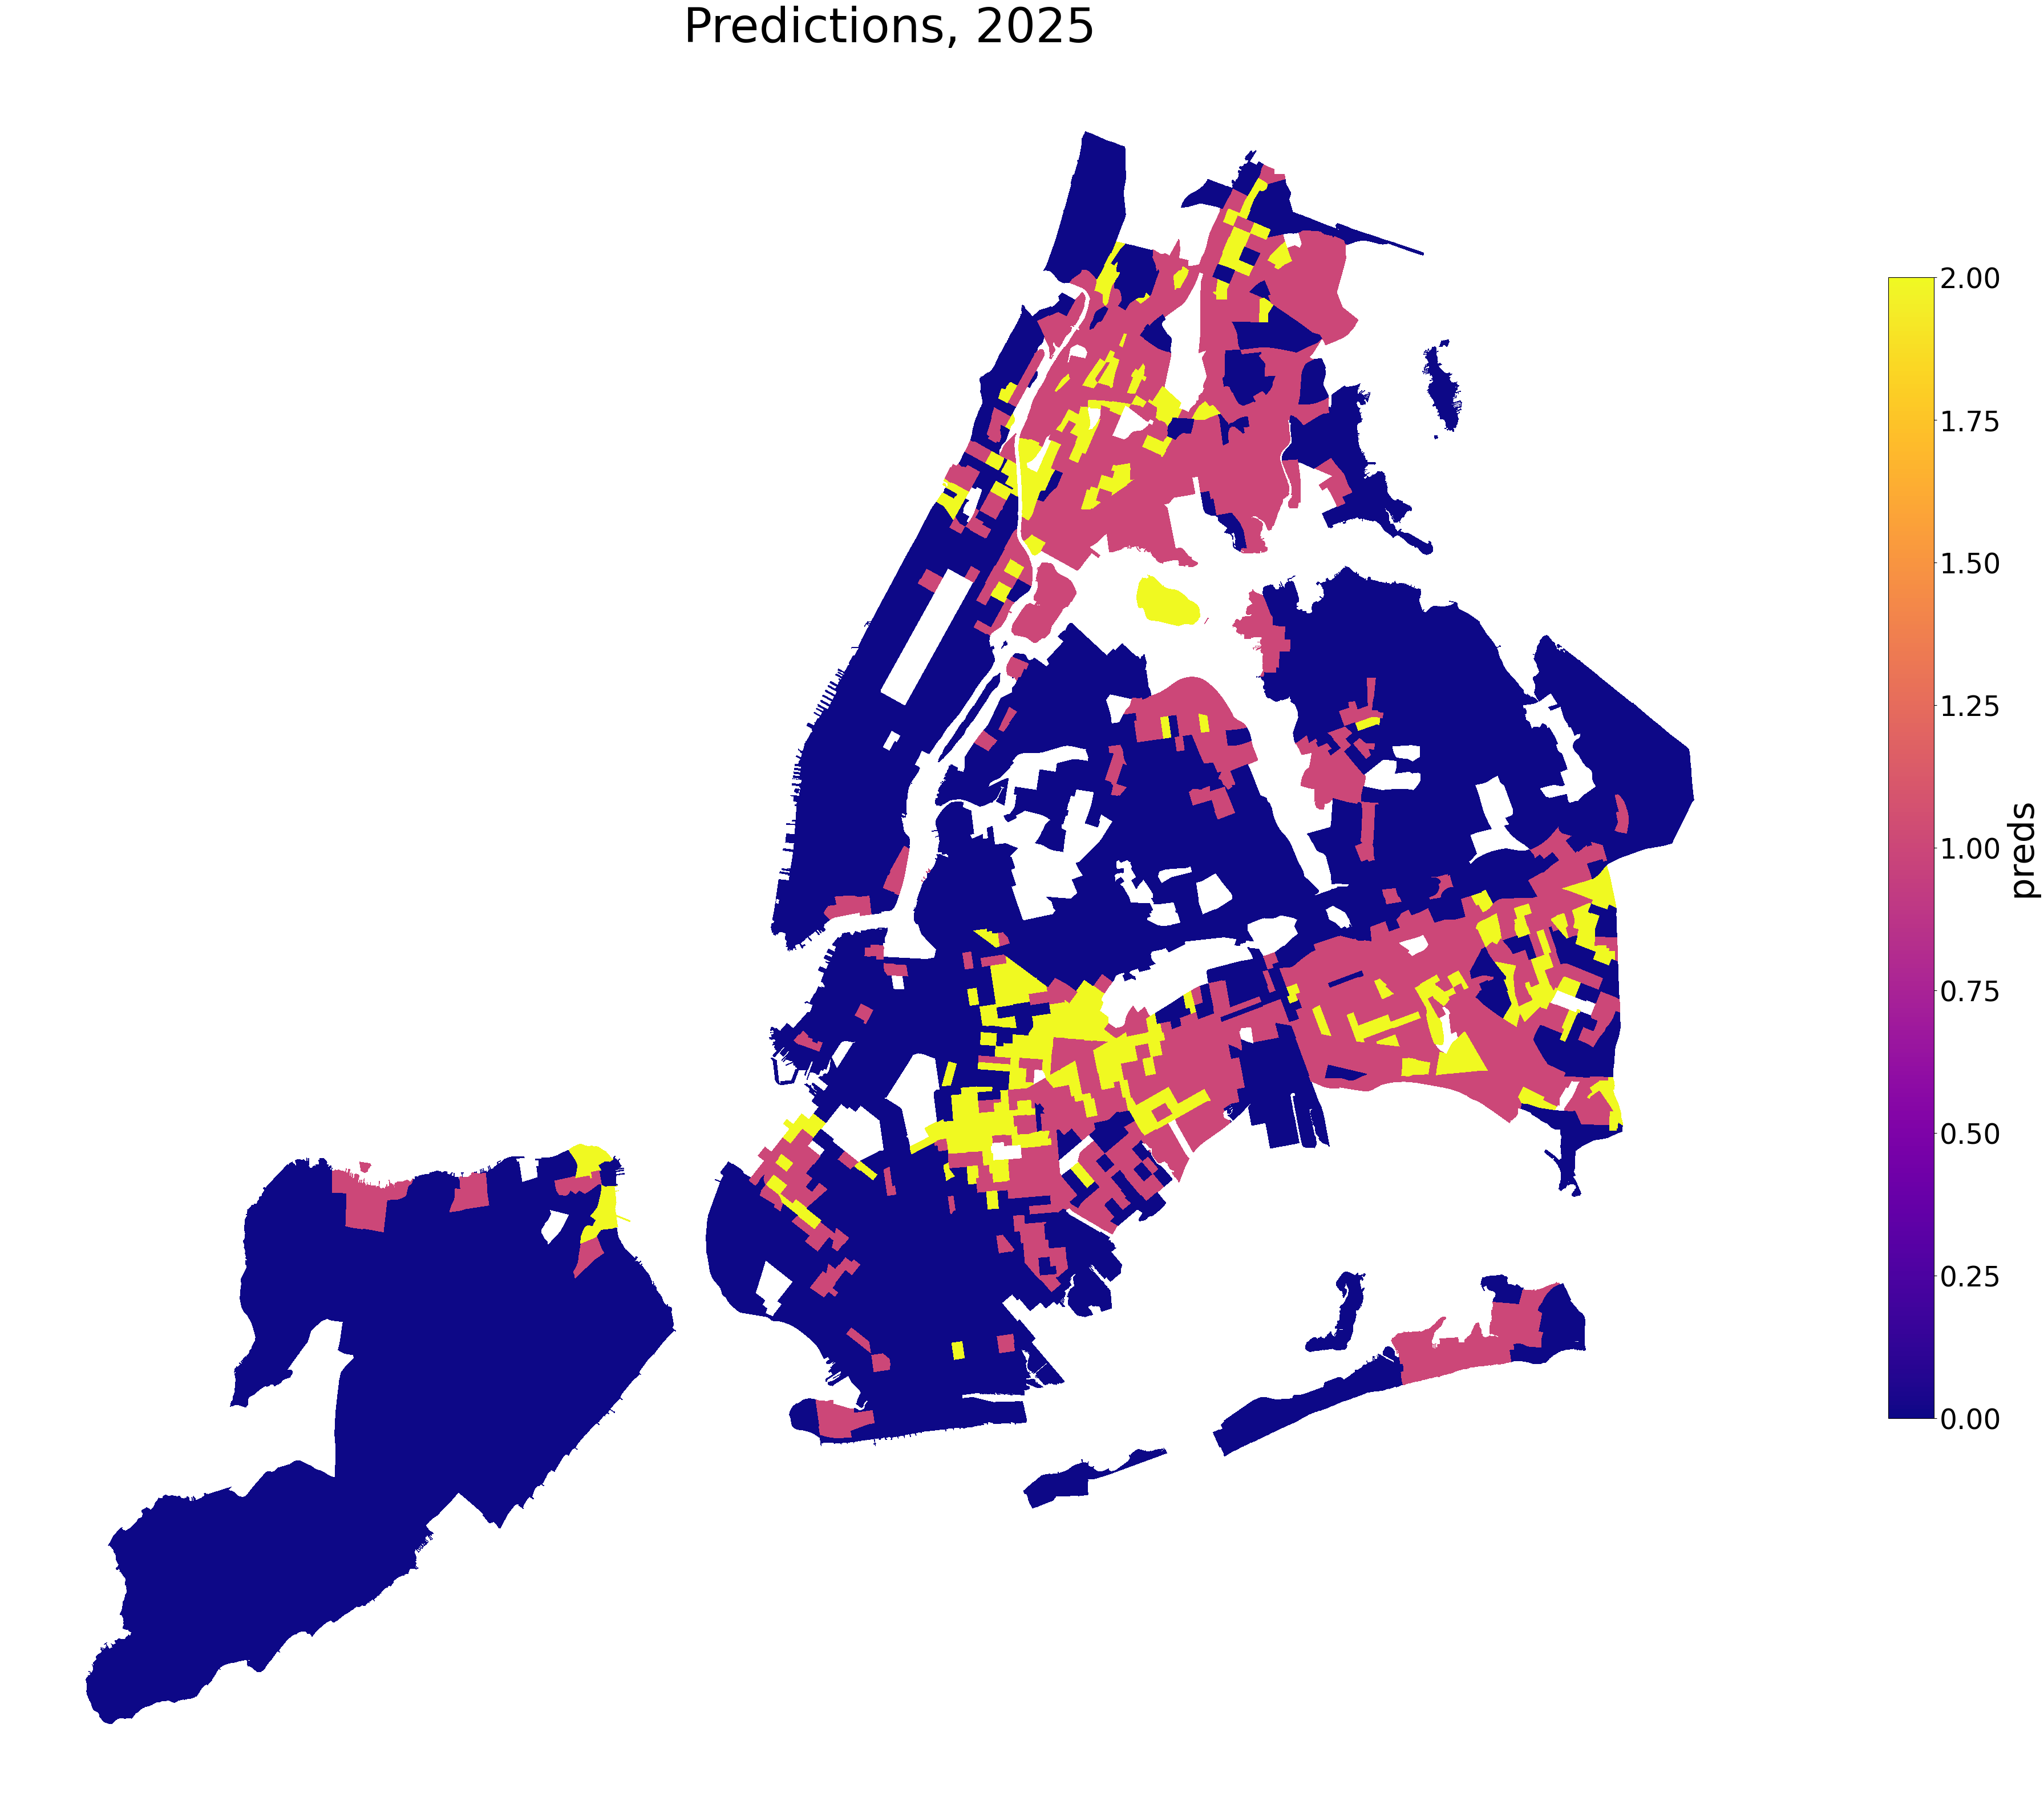

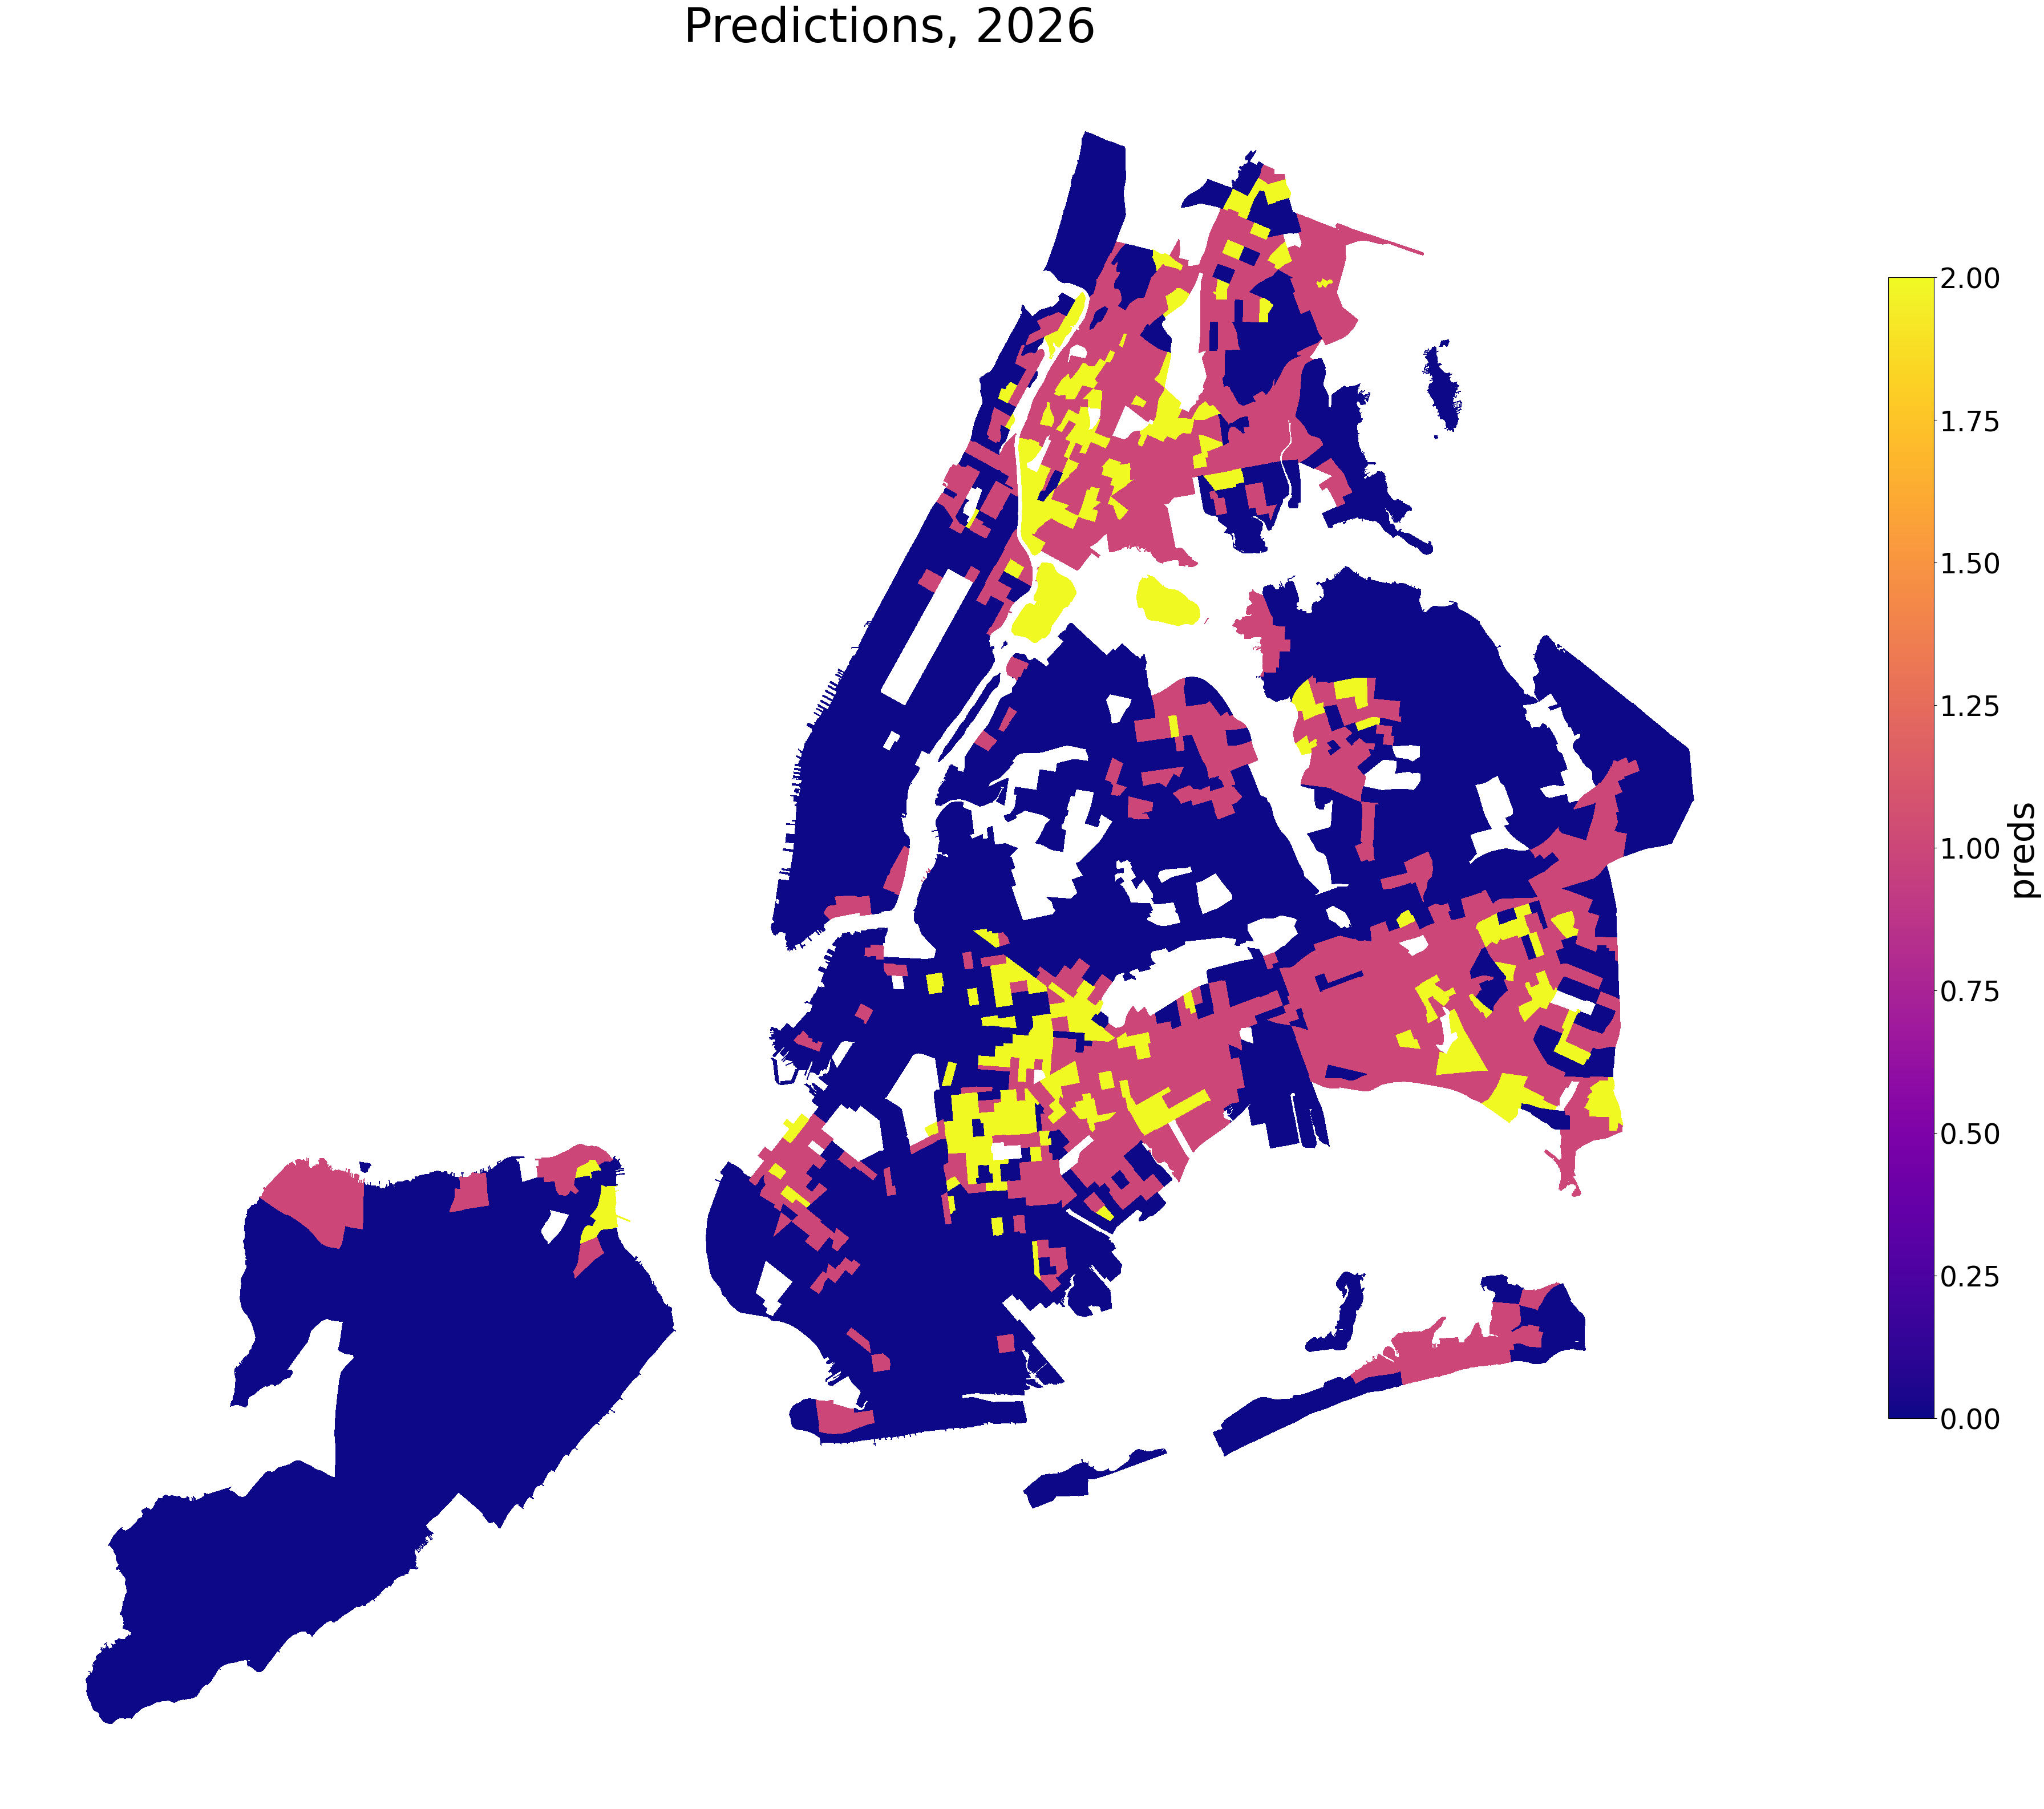

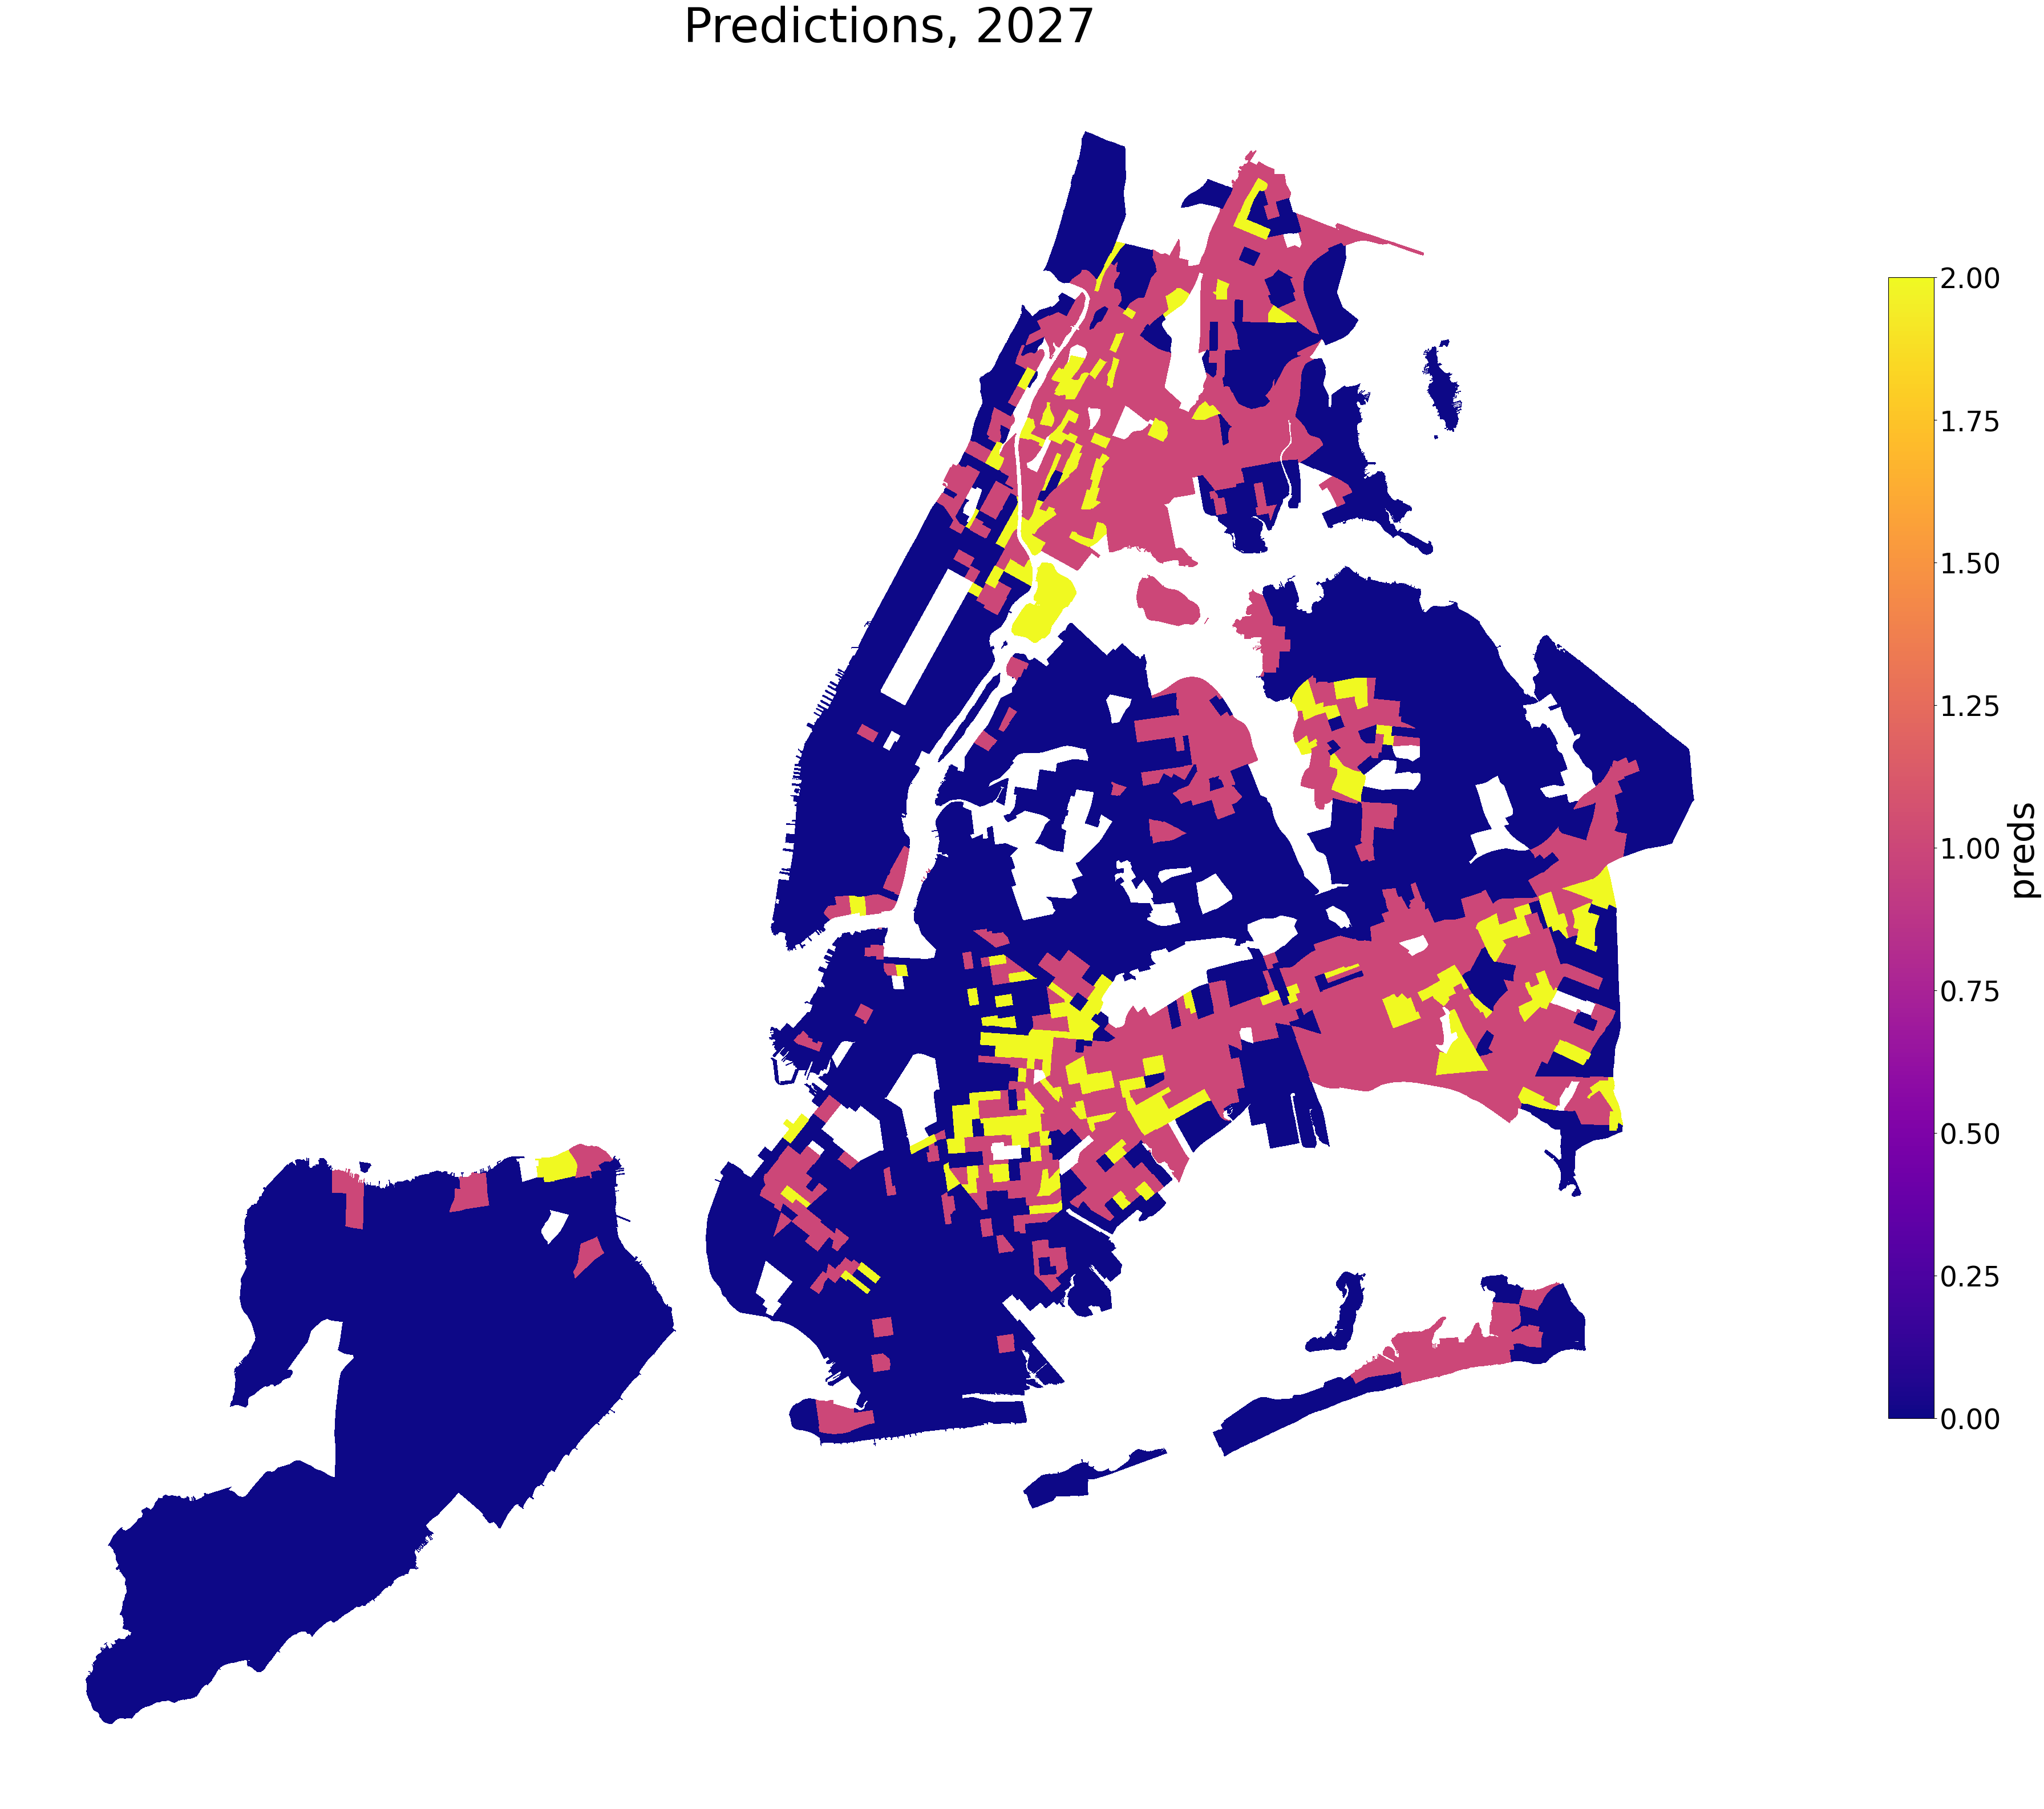

In [19]:
# final preds for 2024-2027

# retrain on full training data
forest.fit(X_train_test, y_train_test)
y_train_test_pred = forest.predict(X_train_test)  # optionally look at training performance

# predict 2027
X_pred = pred_set[feat]
y_final_pred = forest.predict(X_pred)
pred_set['preds'] = y_final_pred
pred_set['preds'] = np.where(pred_set['label']==0, 0, pred_set['preds'])
pred_set.rename(columns={'pred_year':'year'}, inplace=True)

# visualize preds
choropleth(pred_set,'preds',['2024','2025','2026','2027'], cmap='plasma',title='Predictions',save_img=False)

In [20]:
# pred_set.to_parquet('Data/Cleaned/future_preds_udp.parquet')

## Individual Year Predictions
No cross validation used

In [30]:
# Split train/test/pred Set
train_set_full = df[df.pred_year.isin(['2021','2022','2020'])]
test_set_full = df[df.pred_year.isin(['2023'])]

# limit train/test sets to vulnerable/gentrified tracts only
train_set = train_set_full[train_set_full.label!=0]
test_set = test_set_full[test_set_full.label!=0]

# define feature set and split data
feat = ['total_pop', 'percent_hh_income_assist', 'percent_hh_snap',
       'percent_hh_english', 'percent_work_agriculture',
       'percent_work_construction', 'percent_work_retail',
       'percent_work_finance', 'percent_work_stem', 'percent_work_edu_health',
       'percent_work_art', 'percent_out_of_county',
       'percent_moved_within_county', 'percent_public_transit',
       'percent_drive_commute', 'percent_bike_commute', 'percent_walk_commute',
       'percent_wfh', 'percent_white', 'percent_black', 'percent_native',
       'percent_asian', 'percent_pacific', 'percent_latino',
       'percent_bachelors', 'percent_grad', 'percent_born_citizen',
       'percent_naturalized_citizen', 'percent_not_citizen',
       'percent_same_house_1yr', 'percent_out_of_state', 'med_income',
       'med_rent_acs', 'med_age', 'med_value',
       'percent_hh_electric', 'percent_hh_solar', 'med_hh_age',
       'med_hh_tenure', 'num_citibike_rides', 'num_trees', 'med_rent',
       'num_affordable_hous_built', 'num_bikelanes','percent_hh_rented',
       'num_evictions_commercial', 'num_evictions_residential', 'park_acres',
       'num_parks', 'lag_vulnerable']

# labels
y_train = train_set['label']
y_test = test_set['label']

# features
X_train = train_set[feat]
X_test = test_set[feat]

# Apply SMOTE to the training data to upsample minority class
smote = SMOTE(sampling_strategy='auto')
X_train, y_train = smote.fit_resample(X_train, y_train)


In [40]:
###### Fit the Model
forest_yr = RandomForestClassifier(n_estimators=100, random_state=65)
forest_yr.fit(X_train, y_train)
y_train_pred = forest_yr.predict(X_train)
y_test_pred = forest_yr.predict(X_test)

test_set['preds'] = y_test_pred
test_set_full = pd.concat([test_set, test_set_full[test_set_full.label==0]])
test_set_full['year'] = '2023'
test_set_full['preds'].fillna(0, inplace=True)

# performance scores
train_score = f1_score(y_train, y_train_pred)
test_score =  f1_score(y_test, y_test_pred)
print("Train Score:", train_score)
print("Test Score:", test_score)

# visualize preds
# choropleth(test_set_full,'preds',['2023'], cmap='plasma',title='Predictions', save_img=False)
# choropleth(test_set_full,'label',['2023'], cmap='plasma',title='Ground Truth', save_img=False)


Train Score: 1.0
Test Score: 0.880349344978166


# Shap Values

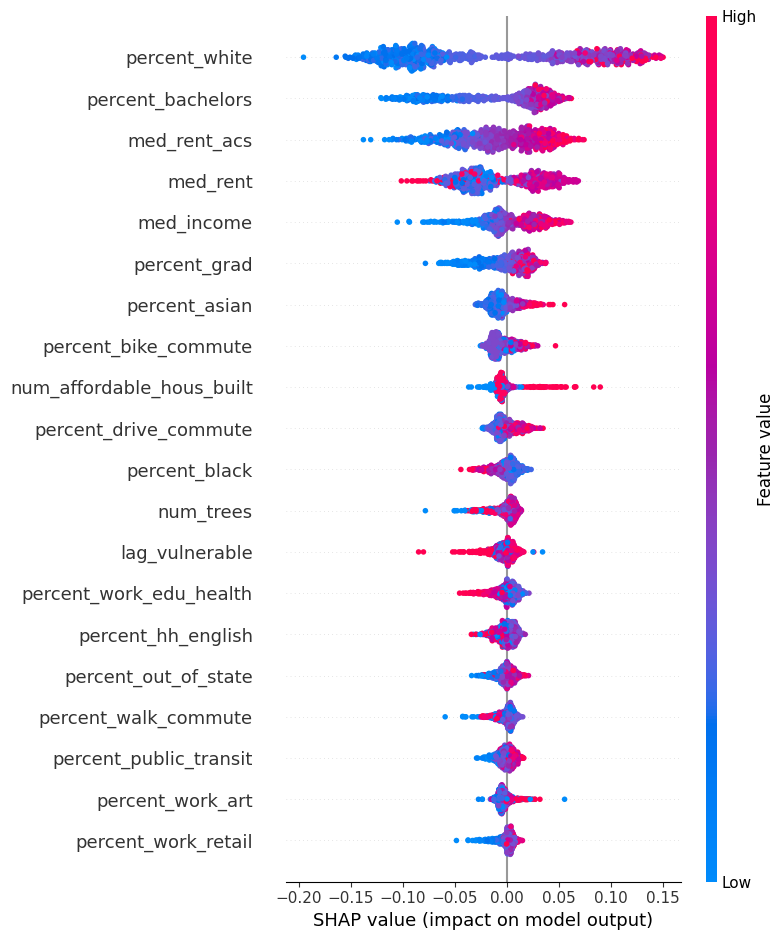

In [67]:
# explainer = shap.Explainer(forest_yr, X_train) 
# shap_values = explainer(X_test)

# Choose the class to explain (1=gentr
class_idx = 1
shap_class1_values = shap_values[:, :, class_idx]

# Plot summary
shap.summary_plot(shap_class1_values, X_test, plot_type='dot');


## Look at individual observations

In [74]:
test_set_full.reset_index(drop=True, inplace=True)


,GEOID,total_pop,percent_hh_income_assist,percent_hh_snap,percent_hh_english,percent_work_agriculture,percent_work_construction,percent_work_retail,percent_work_finance,percent_work_stem,percent_work_edu_health,percent_work_art,percent_out_of_county,percent_moved_within_county,percent_public_transit,percent_drive_commute,percent_bike_commute,percent_walk_commute,percent_wfh,percent_white,percent_black,percent_native,percent_asian,percent_pacific,percent_latino,percent_bachelors,percent_grad,percent_born_citizen,percent_naturalized_citizen,percent_not_citizen,percent_same_house_1yr,percent_out_of_state,med_income,med_rent_acs,med_age,percent_hh_rented,med_value,percent_hh_electric,percent_hh_solar,med_hh_age,med_hh_tenure,num_citibike_rides,num_trees,med_rent,num_affordable_hous_built,num_bikelanes,num_evictions_commercial,num_evictions_residential,park_acres,num_parks,pred_year,lag_vulnerable,label,preds,year
0,36005000100,-0.047073,0.016638,-0.012158,0.008284,0.067606,0.020173,-0.008751,-0.006954,-0.011169,0.000777,0.057227,-0.034618,-0.025811,0.000000,0.000000,0.000000,0.000000,0.000000,0.177417,-0.007267,0.637089,0.052440,0.000000,0.006048,0.127699,-0.052968,0.010279,-0.048080,0.004559,0.121757,-0.069810,0.026201,0.035495,0.029087,-0.011445,0.061120,-0.002745,1.962114,-0.058488,-0.045642,0.0,0.030507,0.003140,0.0,0.000000,0.205246,0.034404,0.0,0.0,2023,1.000000,2,1.0,2023
1,36005000200,-0.009978,0.401031,0.009464,-0.026630,-0.400926,0.106781,0.019265,0.003511,0.027112,0.043052,-0.070731,-0.039493,0.684751,0.018047,-0.068122,0.000000,0.156777,0.166574,0.084972,0.008381,-0.532294,-0.149455,0.000000,0.023200,0.059876,0.323490,-0.000440,-0.044286,0.066791,0.005469,0.118467,-0.047319,0.042043,0.023564,-0.007704,0.001245,0.319306,0.000000,-0.007956,-0.058440,0.0,0.035897,-0.015234,0.0,0.000000,0.000000,0.198413,0.0,0.0,2023,0.574468,1,1.0,2023
2,36005000400,0.006016,0.156690,-0.039909,0.009662,0.000000,-0.026551,0.053427,0.042621,0.033088,0.033527,-0.057681,-0.061982,-0.108334,0.007684,0.016493,-0.105420,-0.304395,1.030631,0.103994,0.010437,0.077795,0.514050,0.000000,0.002885,0.006995,0.126225,0.015030,-0.016199,-0.082058,0.010139,-0.196849,0.013053,-0.008031,0.026936,-0.059510,0.024865,0.110714,0.000000,-0.060978,-0.023846,0.0,0.054317,-0.005563,0.0,0.070962,0.000000,0.212716,0.0,0.0,2023,0.723404,1,1.0,2023
3,36005001600,0.019331,0.241027,0.001394,-0.001416,0.000000,0.026147,0.032472,-0.072322,0.204052,0.009790,0.033445,0.231001,-0.032881,0.033364,-0.023895,0.000000,0.014361,0.442979,0.024685,0.049071,0.000000,2.579927,0.000000,-0.028889,0.124401,0.064652,0.025503,0.017496,-0.009399,0.011418,0.191167,0.018004,0.030656,-0.021151,7.111408,0.033451,0.133954,0.000000,-0.003021,-0.037707,0.0,0.053091,0.010502,-1.0,0.069444,0.000000,0.011564,0.0,0.0,2023,0.714286,1,2.0,2023
4,36005001901,0.016978,-0.007231,-0.009429,0.002618,0.274332,-0.028458,-0.008091,0.064207,-0.013387,0.001317,0.049711,0.021376,-0.078481,0.019546,0.025066,0.244973,0.008909,0.066218,-0.059598,-0.003358,0.082059,-0.040852,0.508779,0.000517,0.012764,0.190979,-0.001738,0.047620,-0.017329,0.005685,0.891248,0.016018,0.250282,0.008227,7.533919,0.044865,0.045163,-0.094430,-0.034766,-0.051932,0.0,0.047510,0.006720,-1.0,0.011111,0.000000,-0.025847,0.0,0.0,2023,0.978723,2,1.0,2023
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2219,36085029104,0.013569,0.370094,0.018394,-0.020985,0.000000,-0.021426,0.000549,-0.014589,-0.039395,0.055523,0.129208,0.168020,0.133548,0.012404,0.001135,0.034211,-0.352959,0.123432,-0.023764,0.281977,0.000000,0.156304,0.000000,0.121045,0.027147,0.034226,-0.023221,0.067694,0.086284,-0.001141,-0.189182,0.045803,0.085128,-0.002297,0.024570,0.036925,0.159761,0.000000,0.003546,-0.025350,0.0,0.005040,-0.013226,0.0,0.000000,-0.520833,-0.500000,0.0,0.0,2023,0.079365,0,0.0,2023
2220,

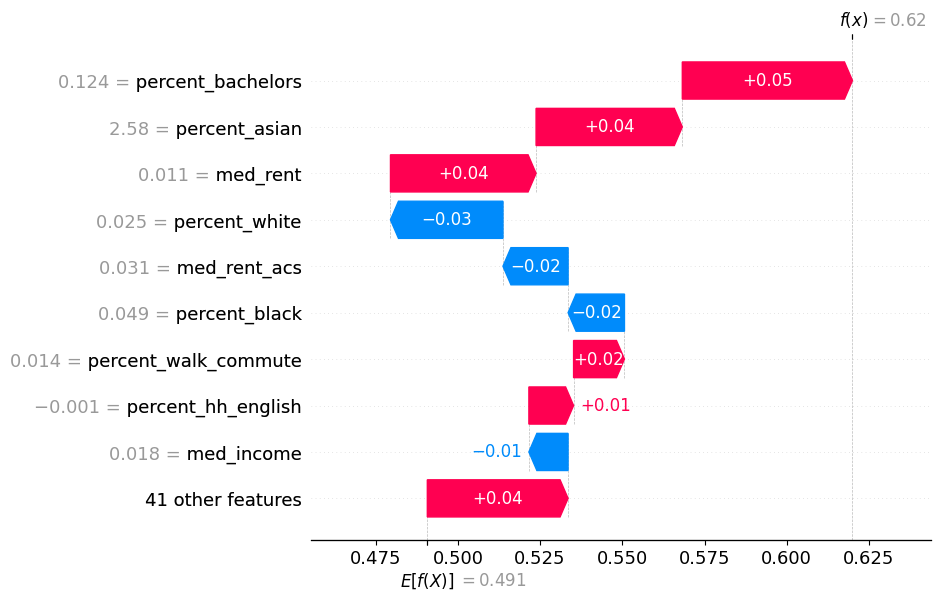

In [65]:
# For a single observation
shap.plots.waterfall(shap_class1_values[3])

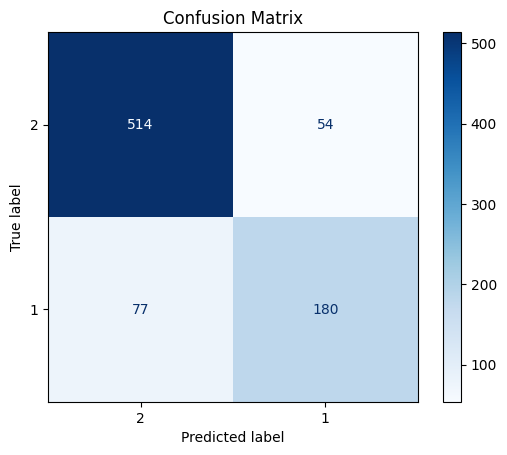

In [48]:
# Create a confusion matrix
cm = confusion_matrix(y_test, y_test_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_set['label'].unique())
disp.plot(cmap=plt.cm.Blues)

# Show the plot
plt.title("Confusion Matrix")
plt.show()